# 第3篇 Pytorch神经网络工具箱学习记录

上一章学习了Pytorch的数据结构及自动求导机制，充分运行这些技术可以大大提高我们的开发效率。这章将介绍Pytorch的另一利器：神经网络工具箱。利用这个工具箱，设计一个神经网络就像搭积木一样，可以极大简化我们构建模型的任务。

## 3.1 神经网络核心组件
神经网络看起来很复杂，节点很多，层数多，参数更多。但核心部分或组件不多，把这些组件确定后，这个神经网络基本就确定了。这些核心组件包括：
（1）层：神经网络的基本结构，将输入张量转换为输出张量。

（2）模型：层构成的网络。

（3）损失函数：参数学习的目标函数，通过最小化损失函数来学习各种参数。

（4）优化器：如何是损失函数最小，这就涉及到优化器。

当然这些核心组件不是独立的，它们之间、以及它们与神经网络其他组件之间有密切关系。为便于大家理解，我们把这些关键组件及相互关系，用图3-1表示。
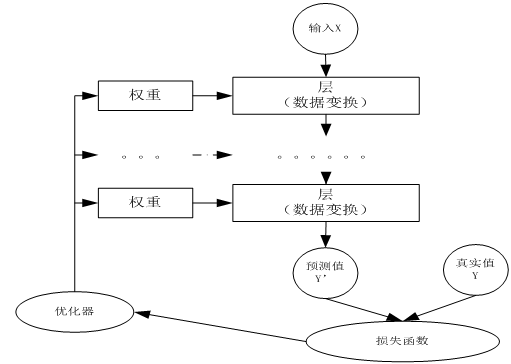
<center>图3-1 神经网络关键组件及相互关系示意图</center>

多个层链接在一起构成一个模型或网络，输入数据通过这个模型转换为预测值，然后损失函数把预测值与真实值进行比较，得到损失值（损失值可以是距离、概率值等），该损失值用于衡量预测值与目标结果的匹配或相似程度，优化器利用损失值更新权重参数，从而使损失值越来越小。这是一个循环过程，损失值达到一个阀值或循环次数到达指定次数，循环结束。这在上一篇的过程已经可以很好的体现了。

接下来利用Pytorch的nn工具箱，构建一个神经网络实例。nn中对这些组件都有现成包或类，可以直接使用，非常方便。

## 3.2实现神经网络实例
使用Pytorch构建神经网络使用的主要工具（或类）及相互关系，如图3-2所示。
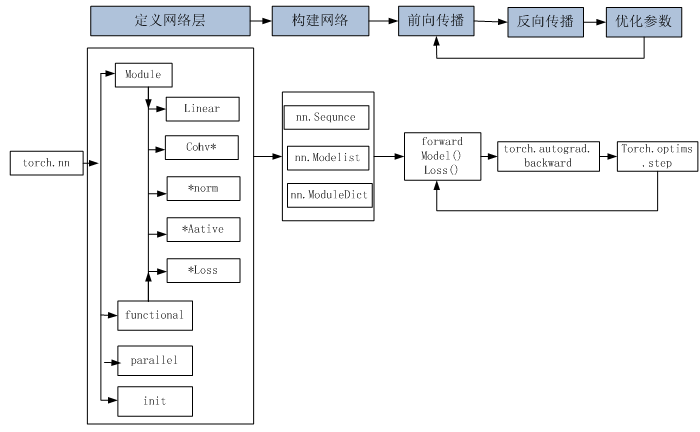
<center>图3-2 Pytorch实现神经网络主要工具及相互关系</center>
从图3-2可知，构建网络层可以基于Module类或函数（nn.functional）。nn中的大多数层（layer）在functional中都有与之对应的函数。nn.functional中函数与nn.Module中的layer的主要区别是后者继承Module类，会自动提取可学习的参数。而nn.functional更像是纯函数。两者功能相同，性能也没有很大区别，那么如何选择呢？像卷积层、全连接层、dropout层等因含有可学习参数，一般使用nn.Module,而激活函数、池化层不含可学习参数，可以使用nn.functional中对应的函数。下面我们通过实例来说明如何使用nn构建一个网络模型。

### 3.2.1背景说明

利用神经网络完成对手写数字进行识别的实例，来说明如何借助nn工具箱来实现一个神经网络，并对神经网络有个直观了解。在这个基础上，后续我们将对nn的各模块进行详细介绍。实例环境使用Pytorch1.0+，GPU或CPU,源数据集为MNIST。
主要步骤：

（1）利用Pytorch内置函数mnist下载数据

（2）利用torchvision对数据进行预处理，调用torch.utils建立一个数据迭代器

（3）可视化源数据

（4）利用nn工具箱构建神经网络模型

（5）实例化模型，并定义损失函数及优化器

（6）训练模型

（7）可视化结果

神经网络的结构如下：
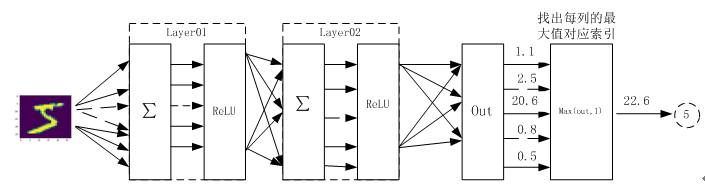

### 3.2.2准备数据

按照我之前的环境配值没有tensorboardX这个库，需要在cmd自己pip install tensorboardX安装一下

In [1]:
import numpy as np
import torch
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist 
# import torchvision
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from tensorboardX import SummaryWriter

In [2]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20

In [3]:
#定义预处理函数
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
#得到一个生成器
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

**【说明】**

①transforms.Compose可以把一些转换函数组合在一起；

②Normalize([0.5], [0.5])对张量进行归一化，这里两个0.5分别表示对张量进行归一化的全局平均值和方差。因图像是灰色的只有一个通道，如果有多个通道，需要有多个数字，如三个通道，应该是Normalize([m1,m2,m3], [n1,n2,n3])

③download参数控制是否需要下载，如果./data目录下已有MNIST，可选择False。

④用DataLoader得到生成器，这可节省内存。

⑤torchvision及data的使用之后将详细介绍。

###  3.2.3可视化源数据

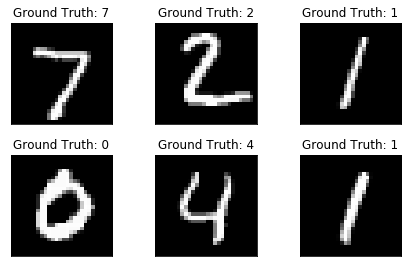

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


### 3.2.4 构建模型

In [5]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        # 找到父类，使用父类的方法初始化
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
 
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

#### 这个地方比较蒙，这模型咋就构建好了呢？
看上面3.2.1的神经网络图，我们一共需要两层加一个输出层，总共三层，所以在Net类里有三个layer。
再说一下这些参数都是啥，
##### __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim)
这个是网络的构造函数，in_dim这里就是网络输入的维度；n_hidden_1是第一层神经元的个数，可以想象成这一层有几个节点；同理n_hidden_2就是第二层神经元的个数，out_dim即输出的维度。
##### Sequential()干了什么
Sequential是一个用来存储计算图的容器，调用Sequential()是向模型中添加一层。
##### Linear()干了什么
每一层他要对数据再次运算处理，Linear()是把做什么呢。以这个模型的为里，输入的是一个长度为28 x 28的向量，第一层是做的就是把这个长度变成n_hidden_1这么长，就相当于做了一个矩阵乘法，之后第二层第三层都是这样，不断的变换得到想要的输出格式。
##### BatchNorm1d()干了什么
BatchNorm1d涉及的东西比较多，简单理解就是使每一层的数据有相同的分布，使数据处于激活函数的敏感阶段。下面这个链接讲的比较细致，可以仔细看看。
https://blog.csdn.net/qq_23262411/article/details/100175943
##### forward()干了什么
forward()函数是干什么的呢，这个函数做的相当于层与层之间的连接，在模型的构造函数里，我们只是定义了每一层都干什么，但是层与层之间这么把输入输出传递呢，需要的就是forward()函数，以上面代码为例，首先把输入的x给到第一层然后，进行relu的激活函数，然后再把得到的结果传到第二层，直到最后一层，返回最后的结果。

In [6]:
lr = 0.01
momentum = 0.9

lr使学习率大家都比较了解了，momentum又是什呢？momentum“冲量”这个概念源自于物理中的力学，表示力对时间的积累效应。那这个参数的作用又是什么呢？
在普通情况下，权重每一次减去学习率×偏导数，而运用冲量后计算公式变为

当本次梯度下降- dx * lr的方向与上次更新量v的方向相同时，上次的更新量能够对本次的搜索起到一个正向加速的作用。当本次梯度下降- dx * lr的方向与上次更新量v的方向相反时，上次的更新量能够对本次的搜索起到一个减速的作用。这样可以使loss值的变换更贴近正确的方向。

In [7]:
#实例化模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#if torch.cuda.device_count() > 1:
#    print("Let's use", torch.cuda.device_count(), "GPUs")
#    # dim = 0 [20, xxx] -> [10, ...], [10, ...] on 2GPUs
#    model = nn.DataParallel(model)
model = Net(28 * 28, 300, 100, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()# 交叉熵函数
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

SGD是最基础的优化方法，普通的训练方法, 需要重复不断的把整套数据放入神经网络NN中训练, 这样消耗的计算资源会很大.当我们使用SGD会把数据拆分后再分批不断放入 NN 中计算. 每次使用批数据, 虽然不能反映整体数据的情况, 不过却很大程度上加速了 NN 的训练过程, 而且也不会丢失太多准确率.

### 3.2.5 训练模型

In [8]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
writer = SummaryWriter(log_dir='logs',comment='train-loss')

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改参数学习率,使学习动态减少，因为后面越接近loss值时候，图像更平缓，步长应该更小
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.9
        print(optimizer.param_groups[0]['lr'])
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 保存loss的数据与epoch数值
        writer.add_scalar('Train', train_loss/len(train_loader), epoch)
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    #net.eval() # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        # 一次训练中预测正确的个数
        acc = num_correct / img.shape[0]
        eval_acc += acc
    # loss值一批次训练数据loss的平均值，准确率一样    
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))

0.009000000000000001
epoch: 0, Train Loss: 0.2235, Train Acc: 0.9369, Test Loss: 0.0952, Test Acc: 0.9711
epoch: 1, Train Loss: 0.0866, Train Acc: 0.9740, Test Loss: 0.0761, Test Acc: 0.9764
epoch: 2, Train Loss: 0.0597, Train Acc: 0.9817, Test Loss: 0.0616, Test Acc: 0.9807
epoch: 3, Train Loss: 0.0447, Train Acc: 0.9863, Test Loss: 0.0657, Test Acc: 0.9788
epoch: 4, Train Loss: 0.0339, Train Acc: 0.9895, Test Loss: 0.0593, Test Acc: 0.9815
0.008100000000000001
epoch: 5, Train Loss: 0.0249, Train Acc: 0.9927, Test Loss: 0.0554, Test Acc: 0.9828
epoch: 6, Train Loss: 0.0189, Train Acc: 0.9945, Test Loss: 0.0521, Test Acc: 0.9823
epoch: 7, Train Loss: 0.0158, Train Acc: 0.9953, Test Loss: 0.0586, Test Acc: 0.9814
epoch: 8, Train Loss: 0.0132, Train Acc: 0.9963, Test Loss: 0.0596, Test Acc: 0.9813
epoch: 9, Train Loss: 0.0118, Train Acc: 0.9966, Test Loss: 0.0490, Test Acc: 0.9846
0.007290000000000001
epoch: 10, Train Loss: 0.0094, Train Acc: 0.9975, Test Loss: 0.0519, Test Acc: 0.9844
e

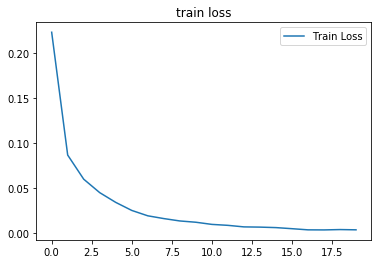

In [9]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
#plt.plot(np.arange(len(eval_losses)), eval_losses)
#plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.legend(['Train Loss'], loc='upper right')


In [11]:
# 将model保存为graph
writer.add_graph(model, (img,))

pip3 install future 这里需要安装一下future

## 3.3 如何构建神经网络？
上节我们用nn工具箱，搭建一个神经网络。步骤好像不少，但关键就是选择网络层，构建网络，然后选择损失和优化器。在nn工具箱中，可以直接引用的网络很多，有全连接层、卷积层、循环层、正则化层、激活层等等。假设这些层都定义好了，接下来就是如何组织或构建这些层？

### 3.3.1 构建网络层
在3.2小节实例中，我们采用torch.nn.Sequential（）来构建网络层，这个有点类似Keras的models.Sequential(),使用起来就像搭积木一样，非常方便。不过，这种方法每层的编码是默认的数字，不易区分。
如果要对每层定义一个名称，我们可以采用Sequential的一种改进方法，在Sequential的基础上，通过add_module()添加每一层，并且为每一层增加一个单独的名字。
此外，还可以在Sequential基础上，通过字典的形式添加每一层，并且设置单独的层名称。
以下是采用字典方式构建网络的一个示例代码：

In [17]:
class Net1(torch.nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv = torch.nn.Sequential(
            OrderedDict(
                [
                    ("conv1", torch.nn.Conv2d(3, 32, 3, 1, 1)),
                    ("relu1", torch.nn.ReLU()),
                    ("pool", torch.nn.MaxPool2d(2))
                ]
            ))

        self.dense = torch.nn.Sequential(
            OrderedDict([
                ("dense1", torch.nn.Linear(32 * 3 * 3, 128)),
                ("relu2", torch.nn.ReLU()),
                ("dense2", torch.nn.Linear(128, 10))
            ])
        )


### 3.3.2 前向传播
定义好每层后，最后还需要通过前向传播的方式把这些串起来。这就是涉及如何定义forward函数的问题。forward函数的任务需要把输入层、网络层、输出层链接起来，实现信息的前向传导。该函数的参数一般为输入数据，返回值为输出数据。
在forward函数中，有些层来自nn.Module,也可以使用nn.functional定义。来自nn.Module的需要实例化，而使用nn.functional定义的可以直接使用。

### 3.3.3 反向传播
前向传播函数定义好以后，接下来就是梯度的反向传播。在第二章，介绍了实现梯度反向传播的方法。这里关键是利用复合函数的链式法则。深度学习中涉及很多函数，如果要自己手工实现反向传播，比较费时。好在Pytorch提供了自动反向传播的功能，使用nn工具箱,我们无需自己编写反向传播，直接让损失函数(loss)调用backward()即可，非常方便和高效！
在反向传播过程中，优化器是一个重要角色。优化方法很多，3.2节采用SGD优化器。此外，我们还可以选择其他优化器，3.7小节将介绍各种优化器的优缺点。

### 3.3.4 训练模型
层、模型、损失函数和优化器等都定义或创建好，接下来就是训练模型。训练模型时需要注意使模型处于训练模式，即调用model.train()。调用model.train()会把所有的module设置为训练模式。如果是测试或验证阶段，需要使模型处于验证阶段，即调用model.eval()。调用model.eval()会把所有的training属性设置为False。
缺省情况下梯度是累加的，需要手工把梯度初始化或清零，调用optimizer.zero_grad()即可。训练过程中，正向传播生成网络的输出，计算输出和实际值之间的损失值。 调用loss.backward()自动生成梯度，然后使用optimizer.step（）执行优化器，把梯度传播回每个网络。
如果希望用GPU训练，需要把模型、训练数据、测试数据发送到GPU上，即调用.to(device)。如果需要使用多GPU进行处理，可使模型或相关数据引用nn.DataParallel。nn.DataParallel的具体使用在第4章将详细介绍。

## 3.4 nn.Module
前面我们使用autograd及Tensor实现机器学习实例时，需要做不少设置，如对叶子节点的参数requires_grad设置为True，然后调用backward,再从grad属性中提取梯度。对于大规模的网络，autograd太过于底层和繁琐。为了简单、有效解决这个问题，nn是一个有效工具。它是专门为深度学习设计的一个模块，而nn.Module是nn的一个核心数据结构。nn.Module可以是神经网络的某个层(layer),也可以是包含多层的神经网络。在实际使用中，最常见的做法是继承nn.Module，生成自己的网络/层，如3.2小节实例中，我们定义的Net类就采用这种方法(class Net(torch.nn.Module))。nn中已实现了绝大多数层，包括全连接层、损失层、激活层、卷积层、循环层等等，这些层都是nn.Module的子类，能够自动检测到自己的Parameter，并将其作为学习参数，且针对GPU运行进行了CuDNN优化。

## 3.5 nn.functional
nn中的层，一类是继承了nn.Module，其命名一般为nn.Xxx(第一个是大写),如nn.Linear、nn.Conv2d、nn.CrossEntropyLoss等。另一类是nn.functional中的函数，其名称一般为nn.funtional.xxx，如nn.funtional.linear、nn.funtional.conv2d、nn.funtional.cross_entropy等。从功能来说两者相当，基于nn.Mudle能实现的层，使用nn.funtional也可实现，反之亦然，而且性能方面两者也没有太大差异。不过在具体使用时，两者还是有区别，主要区别如下：
（1）nn.Xxx继承于nn.Module，nn.Xxx 需要先实例化并传入参数，然后以函数调用的方式调用实例化的对象并传入输入数据。它能够很好的与nn.Sequential结合使用，而nn.functional.xxx无法与nn.Sequential结合使用。
（2）nn.Xxx不需要自己定义和管理weight、bias参数；而nn.functional.xxx需要你自己定义weight、bias，每次调用的时候都需要手动传入weight、bias等参数, 不利于代码复用。
（3）dropout操作在训练和测试阶段是有区别的，使用nn.Xxx方式定义dropout，在调用model.eval()之后，自动实现状态的转换，而使用nn.functional.xxx却无此功能。
总的来说，两种功能都是相同的，但PyTorch官方推荐：具有学习参数的（例如，conv2d, linear, batch_norm)采用nn.Xxx方式。没有学习参数的（例如，maxpool, loss func, activation func）等根据个人选择使用nn.functional.xxx或者nn.Xxx方式。3.2小节中使用激活层，我们采用F.relu来实现，即nn.functional.xxx方式。

## 3.6 优化器
Pytoch常用的优化方法都封装在torch.optim里面，其设计很灵活，可以扩展为自定义的优化方法。所有的优化方法都是继承了基类optim.Optimizer。并实现了自己的优化步骤。
最常用的优化算法就是梯度下降法及其各种变种，后续章节我们将介绍各种算法的原理，这类优化算法使用参数的梯度值更新参数。
3.2小节使用的随机梯度下降法(SGD)就是最普通的优化器,一般SGD并说没有加速效果, 3.2小节使用的SGD包含动量参数Momentum，它是SGD的改良版。
我们结合3.2小结内容，说明使用优化器的一般步骤为：

（1）建立优化器实例
导入optim模块，实例化SGD优化器，这里使用动量参数momentum（该值一般在(0,1)之间），是SGD的改进版，效果一般比不使用动量规则的要好。

In [ ]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

以下步骤在训练模型的for循环中。

（2）向前传播
把输入数据传入神经网络Net实例化对象model中，自动执行forward函数，得到out输出值，然后用out与标记label计算损失值loss。

In [12]:
out = model(img)
loss = criterion(out, label)

（3）清空梯度
缺省情况梯度是累加的，在梯度反向传播前，先需把梯度清零。

In [ ]:
optimizer.zero_grad()

（4）反向传播
基于损失值，把梯度进行反向传播。

In [ ]:
loss.backward()

（5）更新参数
基于当前梯度（存储在参数的.grad属性中）更新参数。

In [ ]:
optimizer.step()

## 3.7 动态修改学习率参数
修改参数的方式可以通过修改参数optimizer.params_groups或新建optimizer。新建optimizer比较简单，optimizer十分轻量级，所以开销很小。但是新的优化器会初始化动量等状态信息，这对于使用动量的优化器（momentum参数的sgd）可能会造成收敛中的震荡。所以，这里我们采用直接修改参数optimizer.params_groups。
optimizer.param_groups:长度1的list，optimizer.param_groups[0]：长度为6的字典,包括权重参数，lr，momentum等参数。

# 3.8 优化器比较
Pytorch中的优化器很多，各种优化器一般都有其适应的场景，不过，像自适应优化器在深度学习中比较受欢迎，除了性能较好，鲁棒性性、泛化能力也更强。这里我们通过一个简单实例进行说明。

（1）导入模块

In [13]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
 
# 超参数
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

（2）生成数据：以y=x^2+0.1为例

In [14]:
# 生成训练数据
# torch.unsqueeze() 的作用是将一维变二维，torch只能处理二维的数据
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)  
# 0.1 * torch.normal(x.size())增加噪点
y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size()))

（3）构建网络和使用多种迭代器

In [15]:
torch_dataset = Data.TensorDataset(x,y)
#得到一个代批量的生成器
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)
 
# 定义模型 
class Net2(torch.nn.Module):
    # 初始化
    def __init__(self):
        super(Net2, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)
 
    # 前向传递
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x
 
net_SGD = Net2()
net_Momentum = Net2()
net_RMSProp = Net2()
net_Adam = Net2()
 
nets = [net_SGD, net_Momentum, net_RMSProp, net_Adam]
 
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_RMSProp = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSProp, opt_Adam]
 
loss_func = torch.nn.MSELoss()
 
loss_his = [[], [], [], []]  # 记录损失

（5）训练和可视化

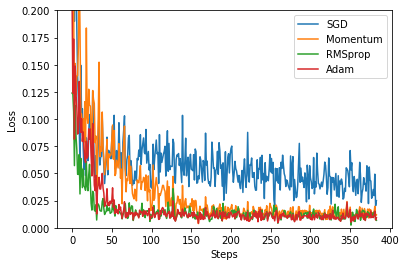

In [16]:
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, opt,l_his in zip(nets, optimizers, loss_his):
            output = net(batch_x)  # get output for every net
            loss = loss_func(output, batch_y)  # compute loss for every net
            opt.zero_grad()  # clear gradients for next train
            loss.backward()  # backpropagation, compute gradients
            opt.step()  # apply gradients
            l_his.append(loss.data.numpy())  # loss recoder
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
for i, l_his in enumerate(loss_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()

## 3.9 小结

这一次的学习利用pytorch中的工具进行构建网络进行训练，其中有许多新的概念，以前两章的内容还不能完全理解这次的内容，还是需要不会的地方就查。总结一下这次新学到的知识，首先是通过torch.nn来构建模型，利用optimizer优化器来方便训练，和各种的迭代器，动态修改学习率，loss值加冲量的计算。这次的东西确实比较乱而且多，但是都做下来感觉和机器学习更近了一步。